## European Call Option Hedging

# Imports

In [1]:
import torch
import ml_adp.cost, ml_adp.finance, ml_adp.nn, ml_adp.mapping
import matplotlib.pyplot as plt
import copy

# Device Settings

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Derivative Hedging

Consider the example of an investor hedging a European contingent claim $H$ in a financial market of $d$ securities and $T$ trading periods until the maturity of $H$.
We identify the securities with their price processes $P^{(1)},\dots, P^{(d)}$ which we assume to be non-negative stochastic processes on a probability space $(\Omega, \mathcal{F}, \mathbb{P})$ adapted to a filtration $(\mathcal{G}_t)_{t=0}^T$. 
Additionally, $P^{(0)}$ shall refer to the money market account/security.

We assume the market to have independent increments, meaning that for every security $S^{(i)}$ the process of its excess returns $$R^{(i)}_t = \Delta P^{(i)}_{t+1} / P^{(i)}_t,\quad t=0,\dots, T$$ as a family of random variables, is independent. 

The investor's self-financing hedging strategy corresponds to an adapted process $(a_0,\dots, a_T)$ with positions in $\mathbb{R}^d$ indicating at each time the net amounts invested into all but one designated asset of market's primary securities:
For the portfolio to indeed be self-financing, the missing position in the designated asset - which we take to be the money market account $P^{(0)}$) - must be $a^{(0)}_t = \sum_{i=1}^d a^{(i)}_t$.  
Given some initial level $w_0$ of funds invested into the strategy $a$, the corresponding *wealth process* $w_t$ is given by $$w_{t+1} = w_t + a_t\cdot R_{t+1} + (w_t - \sum_t a_t)R^{(0)}_{t+1}.$$
It is the hedging investor's objective to incur a minimal *square replication error* $|w_T - H|^2$ and the tool at his disposal is the varying amount of initial endowment $w_0$:
If the claim $H$ is attainable, then the initial endowment $w_0$ for wh

We recognize this problem to be a particular instance of a stochastic optimal control problem $OCP$ for which at each time $t$ the state relevant to the investor is the current wealth of his portfolio together with the current market state: $s_t = (w_t, r_t)$ and that the investor controls the problem through his investments $\tilde{a}_t$ into the risky asset.
$$F_t(s_t, a_t)  = (w_t + \tilde{a}_t\cdot r_{t+1}, (1 + r_t)s_t)$$
which as a random function can easily can be seen to factorize into a function on Euclidean space $\tilde{F}$ over the excess returns: $F_t(s_t, a_t) = \tilde{F}(s_t, a_t, R_{t+1})$ with 
$$\tilde{F}(s_t, a_t, r_{t+1}) = (w_t + \tilde{a}_t\cdot r_{t+1}, (1 + r_{t})s_t)$$

Setting $k_0,\dots, k_{T-1}$ to zero and $$k_T(s_T, a_T) = |H(s_T) - w_T|$$ we find all these to be deterministic cost functions.

With such being so, we find the optimal control problem $OCP_{\mathcal{G}_t, F, k}$ to express the agent's objective and for the problem to lie in the scope of `ml_adp`.

# Market Specification

More concretely, we take for the example

* the financial market to have $5$ trading periods and consist of a single risky asset trading at a current level of $100$: $T=5$, $d=1$ and $P_0 = 100$ (setting $P=P^{(1)}$ and $R=R^{(1)}$)
* A multinomial model for the securities returns: $R_0,\dots, R_T$ i.i.d. with law either $(3/10*\delta_{\{-0.05\}} + 1/10*\delta_{\{0\}} + 6/10 * \delta_{\{0.05\}})$ (giving a multinomial model) or $LogN(\mu, \sigma)$ (giving the discrete-time Black-Scholes model)
* The locally risk-free asset yielding nothing: $R_t^{(0)} = 0$ for all times $t$

In [3]:
number_periods = 5
number_risky_assets = 1

risk_free_rate = 0.

initial_value = 100.

rets = torch.tensor([0.05, -0.05, 0.0]).to(device)
probs = torch.tensor([0.6, 0.3, 0.1]).to(device)
multinomial_returns_sampler = ml_adp.finance.MultinomialReturnsSampler(rets, probs)

black_scholes_sampler = ml_adp.finance.BlackScholesReturnsSampler(0.0, 1.0)

Also, we take $H$ to be a European call option on $S$ with maturity $5$ and strike equal to the initial price of $S$: $$H = (S_5 - 100)^+.$$
The module :py:class:`ml_adp.finance.EuropeanCallOption` implements such claims:

In [4]:
option = ml_adp.finance.EuropeanCallOption(strike=100., underlying_index=1)

As a callable, ``option`` will accept samples of states $s_T=(w_T, p_T)$ and produce the corresponding sample of payoffs.
Given any such callable, :py:class:`ml_adp.finance.SquareReplicationError` will produce the square replication error.
:py:class:`ml_adp.finance.MarketStep`` instead implements the state transition function $\tilde{F}$.

In [5]:
square_replication_error = ml_adp.cost.CostToGo.from_steps(number_periods)
square_replication_error.state_functions[:-1] = ml_adp.finance.MarketStep(risk_free_rate)
square_replication_error.cost_functions[-1] = ml_adp.finance.SquareReplicationError(option)

We know the analytical solution for this case:

In [6]:
def v0(wp, excess_returns=None):
    wealth = wp[:, [0]]
    return .577 * (wealth ** 2) - 5.355 * wealth + 12.413248637

analytic_cost = ml_adp.cost.CostToGo.from_steps(0)
analytic_cost.cost_functions[0] = v0

The option has an analytic value of $4.5$:

In [7]:
analytic_cost(torch.tensor([4.5]))

tensor([[0.]])

# Control Function Specification

We are now at the point where the neural networks to be used as the control functions must be specified which generally is an exercise of the domain expert.
He will have noticed that, in the present case, the lack of dependence of the cost functions on the random effects (deterministic costs) implies an optimal control, effectively, to also not depend on the random effects. 
Moreover, he will be informed (by e.g. [arXiv:1812.05916v3](https://arxiv.org/abs/1812.05916v3)) that, in the given situation, the optimal control will depend linearly on the wealth level at each step and that the price levels parametrize the linear dependences.
:py:class:`ml_adp.mapping.linear.LinearMap` implements learnable such parametrized linear maps:


In [8]:
class PFStrat(torch.nn.Module):
    def __init__(self, number_risky_assets, hidden_layer_sizes):
        super(PFStrat, self).__init__()
        config = [number_risky_assets] + list(hidden_layer_sizes) + [(number_risky_assets, 1)]
        self.linear_map = ml_adp.mapping.linear.LinearMap.from_ffnconfig(config, translate=False)

    def forward(self, state, rand_eff):  # Deterministic Cost mean no rand_effs needed
        # Inputs to the linear map is the wealth, parameter is the price
        return self.linear_map(state[:, [0]], state[:, 1:])

A single hidden layer with $40$ neurons has been identified to work well for the controls of this particular instance of the option hedging problem:

In [9]:
hidden_layer_sizes = (30, 30)

Set the control functions:

In [10]:
for i in range(len(square_replication_error) - 1):
    square_replication_error.control_functions[i] = PFStrat(number_risky_assets, hidden_layer_sizes)

Inspect ``square_replication_error``:

In [11]:
square_replication_error

CostToGo(
step |       state_func       |      control_func      |       cost_func        
   0                                PFStrat(train)                None          
   1       MarketStep(-)            PFStrat(train)                None          
   2       MarketStep(-)            PFStrat(train)                None          
   3       MarketStep(-)            PFStrat(train)                None          
   4       MarketStep(-)            PFStrat(train)                None          
   5       MarketStep(-)                 None              SquareRepl...or(-)   
  (6)           None                                                            
)

# Training States Sampling

For the training distributions, the domain expert defaults to a normal distribution that for the wealths has 95% of its mass contained in the interval $[0, 10]$ (which is expected to contain the price of the option) and for the prices a normal distribution centered at the initial price $100$ and with the standard deviation increasing based on the number of trading periods into the market (which is expected to).

In [12]:
from torch.distributions import multivariate_normal

class StateSampler:
    def __init__(self, step):
        loc = torch.tensor([5., initial_value]).to(device)
        scale = torch.diag(torch.tensor([2.5**2, (initial_value * (1+0.05)**max(step, 1)) - initial_value]))
        self.sampler = multivariate_normal.MultivariateNormal(loc, scale)
    
    def __call__(self, sims_size):
        return self.sampler.sample((sims_size,))

state_samplers = [StateSampler(step) for step in range(len(square_replication_error))]

We produce a dictionary containing the relevant cost-to-go and samplers.

In [13]:
model = {'cost_to_go': square_replication_error,
         'state_samplers': state_samplers,
         'random_effects_samplers': len(square_replication_error) * [multinomial_returns_sampler]}

# NNContPi

The following hyper parameters related to the optimization have been identified to work well for this particular problem:

Create a fresh copy of the model:

In [14]:
model = copy.deepcopy(model)

cost_to_go = model['cost_to_go']
state_samplers = model['state_samplers']
random_effects_samplers = model['random_effects_samplers']


In [15]:
gradient_descent_steps = 400  # Number of gradient descent steps performed for the optimization at each time step

# Optimizer Parameters:
optimizer_name = "Adam"
learning_rate = 0.01178377519990234  # 0.04693097149946282
gamma = 0.999

Choose the sample size for the Monte-Carlo simulation and perform the optimization routine:

In [25]:
sims_size = 10000  # Monte-Carlo Simulation Size

print("Optimizing the following model using NNContPi-Algorithm:")
print(cost_to_go)
print(80 * "-")

for step in reversed(range(len(cost_to_go) - 1)):
    
    state_sampler = state_samplers[step]
    random_effects_sampler = random_effects_samplers[step]

    rel_cost_to_go = cost_to_go[step:]
    optimizer = getattr(torch.optim, optimizer_name)(rel_cost_to_go.control_functions[0].parameters(), lr=learning_rate)

    print("Minimizing the first control of")
    rel_cost_to_go.descr(optimizer=optimizer, include_id=True)

    for iteration in range(gradient_descent_steps):

        states = state_sampler(sims_size)
        rand_effs = random_effects_sampler(sims_size, len(rel_cost_to_go))

        cost = rel_cost_to_go(states, rand_effs).mean()

        if iteration % 50 == 0:
            print(f"Step {step}, MC Iteration {iteration}: Cost {cost}")

        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    rel_cost_to_go.eval()
    print(80 * "-")

Optimizing the following model using NNContPi-Algorithm:
CostToGo(
step |       state_func       |      control_func      |       cost_func        
   0                                PFStrat(train)                None          
   1       MarketStep(-)            PFStrat(train)                None          
   2       MarketStep(-)            PFStrat(train)                None          
   3       MarketStep(-)            PFStrat(train)                None          
   4       MarketStep(-)            PFStrat(train)                None          
   5       MarketStep(-)                 None              SquareRepl...or(-)   
  (6)           None                                                            
)
--------------------------------------------------------------------------------
Minimizing the first control of
CostToGo(
step |       state_func       |      control_func      |       cost_func        
   0                            X P...at(train;..6704)             None        

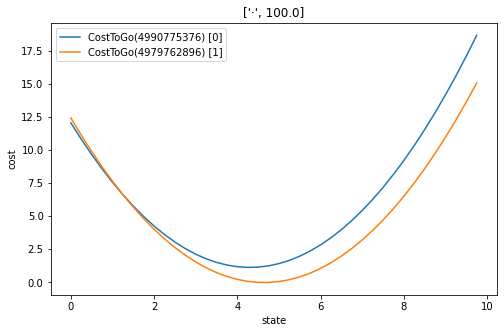

In [28]:
rand_effs = random_effects_samplers[-1](10000, len(cost_to_go))
with ml_adp.cost._evaluating(cost_to_go), torch.no_grad():
    cost_to_go.plot_state_component_range(torch.arange(0, 10, 0.25).to(device), torch.arange(100., 101., 1.).to(device), random_effects=rand_effs, versus=analytic_cost, plot_size=(8,5))

# HybridNow

We start anew:

In [18]:
model = copy.deepcopy(model)

cost_to_go = model['cost_to_go']
state_samplers = model['state_samplers']
random_effects_samplers = model['random_effects_samplers']

We perform the optimization using the HybridNow algorithm that includes value function approximation at each of the optimization steps of the above algorithm ensuring a constant run-time for each of the optimization steps.
The domain expert will notice that the convexity of the cost function in the wealth-level translates to the convexity of the expected total cost in the wealth.
He decides to apply *partially input-convex neural networks* (as introduced in [arXiv:1609.07152v3](https://arxiv.org/abs/1609.07152v3) and implemented by :py:class:`ml_adp.mapping.convex.PICNN1`) for value function approximation for which he expects the search space to be more efficiently traversed: 

In [19]:
class PFVal(torch.nn.Module):
    def __init__(self, input_hidden_sizes, param_hidden_sizes):
        super(PFVal, self).__init__()
        
        input_config = (1, *(input_hidden_sizes), 1)
        param_config = (1, *(param_hidden_sizes), 1)

        self.picnn = ml_adp.mapping.convex.PICNN1( 
                            input_config, 
                            param_config, 
                            output_activation=None, 
                            param_hidden_activation=torch.nn.ReLU(),
                            floor_func=torch.nn.Softplus()
                            )

    def forward(self, states, rand_effs=None):
        return self.picnn(states[:, [0]], states[:, 1:])

The following configurations have proven themselves to work well for the optimal control problem at hand:

In [20]:
input_hidden_sizes = (35,35)
param_hidden_sizes = (55,55)

# For the optimization of the PICNNs
approximation_optimizer = "SGD"
approximation_lr = 0.015002935353031616
approximation_gamma = 0.9998846278130944

approximation_gradient_descent_steps = 400


Choose hyperparamters that have been empirically discovered to perform well:

Optimizing the following costtogo:
CostToGo(
step |       state_func       |      control_func      |       cost_func        
   0                            X P...at(train;..6704)             None         
   1       M...ep(-;..6720)               None               S...or(-;..0464)   
  (2)            None                                                           
)
Step 4 Control Optimization: MC Iteration    0, Cost      15.7492647171
Step 4 Control Optimization: MC Iteration  100, Cost      16.3075141907
Step 4 Control Optimization: MC Iteration  200, Cost      15.6237630844
Step 4 Control Optimization: MC Iteration  300, Cost      15.6408128738
Minimzing L2 distance between:
CostToGo(
step |       state_func       |      control_func      |       cost_func        
   0                                      None           X PFVal(train;..5760)  
  (1)            None                                                           
)
CostToGo(
step |       state_func       |      control_

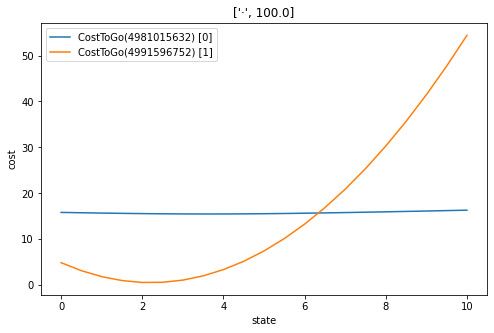

Step 4 Value Approximation: MC Iteration  200, Approximation Error     701.5390625000


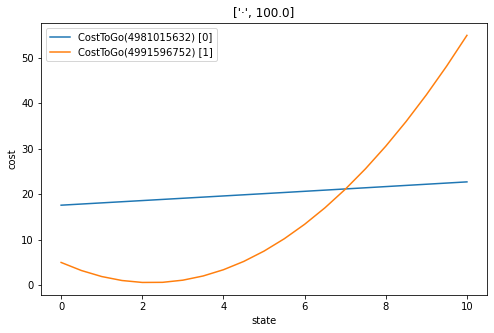

Step 4 Value Approximation: MC Iteration  300, Approximation Error     712.9092407227


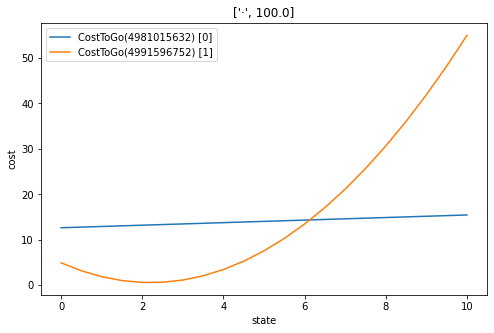

Optimizing the following costtogo:
CostToGo(
step |       state_func       |      control_func      |       cost_func        
   0                            X P...at(train;..8064)             None         
   1       M...ep(-;..6720)               None           -  PFVal(eval;..5760)  
  (2)            None                                                           
)
Step 3 Control Optimization: MC Iteration    0, Cost      15.6983175278
Step 3 Control Optimization: MC Iteration  100, Cost      14.3892269135


KeyboardInterrupt: 

In [21]:
sims_size = 6000
approximation_batch_size = 30

cost_approximators = []

cost_approximator = cost_to_go[-1]  # This can be taken exact

for step in reversed(range(len(cost_to_go) - 1)):

    state_sampler = state_samplers[step]
    random_effects_sampler = random_effects_samplers[step]

    sub_ctg = cost_to_go[step] + cost_approximator

    sub_ctg.control_functions[0].train()
    optimizer = getattr(torch.optim, optimizer_name)(sub_ctg.control_functions[0].parameters(), lr=learning_rate)

    print("Optimizing the following costtogo:")
    print(sub_ctg.__repr__(optimizer=optimizer, include_id=True))

    for epoch in range(gradient_descent_steps):

        rand_effs = random_effects_sampler(sims_size, len(rel_cost_to_go))
        state = state_sampler(sims_size)
        
        cost = sub_ctg(state, rand_effs).mean()

        if epoch % 100 == 0:
            print(f"Step {step} Control Optimization: MC Iteration {epoch : >4}, Cost {cost : >18.10f}")

        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

    sub_ctg.eval()

    cost_approximator = ml_adp.cost.CostToGo.from_steps(0)
    cost_approximator.cost_functions[-1] = PFVal(input_hidden_sizes, param_hidden_sizes)
    cost_approximator.eval()
    cost_approximator.to(device)
    cost_approximators.append(cost_approximator)

    cost_approximator.cost_functions[0].train()    
    optimizer = torch.optim.Adam(cost_approximator.cost_functions[0].parameters(), lr=approximation_lr)

    print("Minimzing L2 distance between:")
    print(cost_approximator.__repr__(optimizer=optimizer, include_id=True))
    print(rel_cost_to_go.__repr__(optimizer=optimizer, include_id=True))

    for epoch in range(approximation_gradient_descent_steps):
        
        state = state_sampler(approximation_batch_size)
        rand_effs = random_effects_sampler(sims_size, len(sub_ctg))
        
        approx_cost = cost_approximator(state)
        cost = torch.tensor([sub_ctg(state, rand_effs).mean() for state in state])
        
        approx_error = torch.norm(cost - approx_cost, p=2)
            
        if epoch % 100 == 0:
            print(f"Step {step} Value Approximation: MC Iteration {epoch : >4}, Approximation Error {approx_error.item() : >18.10f}")

        if epoch % 100 == 0 and epoch > 0:
            cost_approximator.plot_state_component_range(
                torch.arange(0., 10.5, 0.5).to(device),
                torch.arange(100., 101.).to(device),
                random_effects=rand_effs,
                versus=sub_ctg,
                plot_size=(8,5)
            )
            plt.show()

        approx_error.backward()
        optimizer.step()
        optimizer.zero_grad()

    cost_approximator.eval()
    